In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

# For processing
import math

# For visualization
import matplotlib.pyplot as plt

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [2]:
# Reading our dataset
df = pd.read_csv('RUBY.csv', parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-11-08,7.0,7.0,7.0,7.0,7.0,500
1,2008-01-09,7.0,7.0,7.0,7.0,7.0,500
2,2008-01-15,6.5,6.5,6.5,6.5,6.5,500
3,2008-01-22,6.5,6.5,6.5,6.5,6.5,500
4,2008-02-04,6.5,6.5,6.5,6.5,6.5,1000


In [3]:
new_df = df.reset_index()['Close']

In [7]:
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [8]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [10]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [11]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1604, 60)
(1604,)


Testing set size:-
(356, 60)
(356,)


(None, None)

In [12]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# Initialize a sequential model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))        

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [15]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100

51/51 [==============================] - 6s 48ms/step - loss: 0.0128 - val_loss: 0.0042
Epoch 2/100
51/51 [==============================] - 2s 30ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 3/100
51/51 [==============================] - 2s 30ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 4/100
51/51 [==============================] - 2s 30ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 5/100
51/51 [==============================] - 1s 29ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 6/100
51/51 [==============================] - 2s 29ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 7/100
51/51 [==============================] - 2s 30ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/100
51/51 [==============================] - 1s 29ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 9/100
51/51 [==============================] - 1s 29ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 10/100
51/51 [==============================] - 2s 30ms/step - loss: 0.0028 - val_loss: 0.001

In [17]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

12/12 [==============================] - 0s 18ms/step


In [18]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

8.160729096321234
12.866559853898368


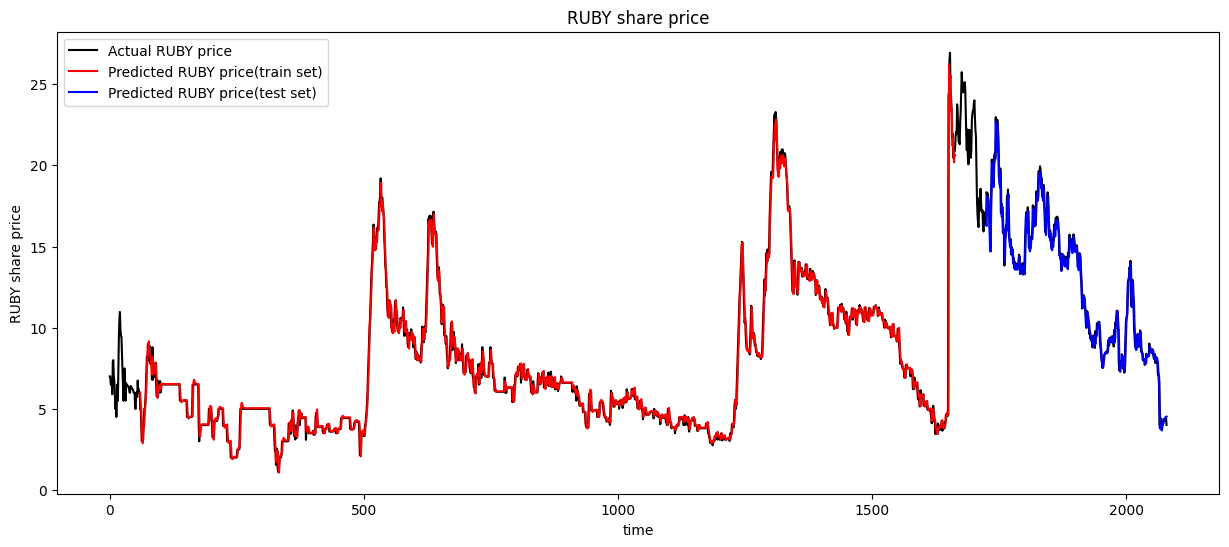

In [20]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan

trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan

test_start = len(new_df) - len(test_predict)

testPredictPlot[test_start:] = test_predict.flatten()

original_scaled_data = scaler.inverse_transform(scaled_data)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual RUBY price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted RUBY price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted RUBY price(test set)")

plt.title("RUBY share price")
plt.xlabel("time")
plt.ylabel("RUBY share price")
plt.legend()
plt.show()

In [21]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 [==============================] - 0s 36ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 4.52236795425415
Day 2: Predicted Price = 4.569398880004883
Day 3: Predicted Price = 4.616466999053955
Day 4: Predicted Price = 4.662722587585449
Day 5: Predicted Price = 4.708139419555664
Day 6: Predicted Price = 4.752840995788574
Day 7: Predicted Price = 4.796943187713623
Day 8: Predicted Price = 4.840543270111084
Day 9: Predicted Price = 4.88371467590332
Day 10: Predicted Price = 4.926511287689209


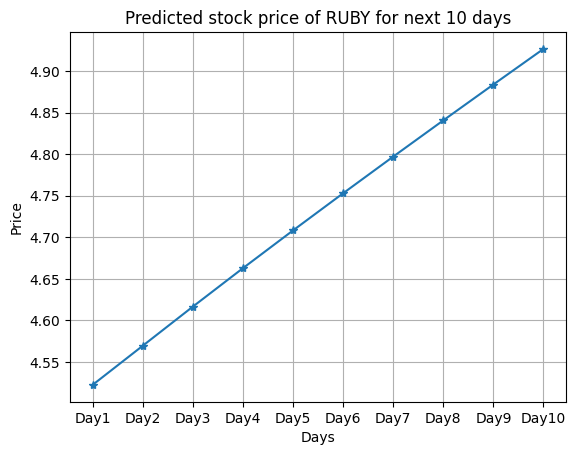

In [22]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of RUBY for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()

# `Bi-LSTM`